In [1]:
import numpy as np
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.response_functions.features import compute_returns

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 1000

## Load market orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [6]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.015541
 2       0.001610
 3       0.005973
 4       0.005574
           ...   
 996    -0.001168
 997     0.000533
 998     0.001713
 999    -0.000517
 1000   -0.000748
 Length: 1001, dtype: float64)

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.78
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.00
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.79
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 1.2. Return Autocorrelation Functions (ACFs)

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [8]:
# Save data for lazy loading
linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [9]:
nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


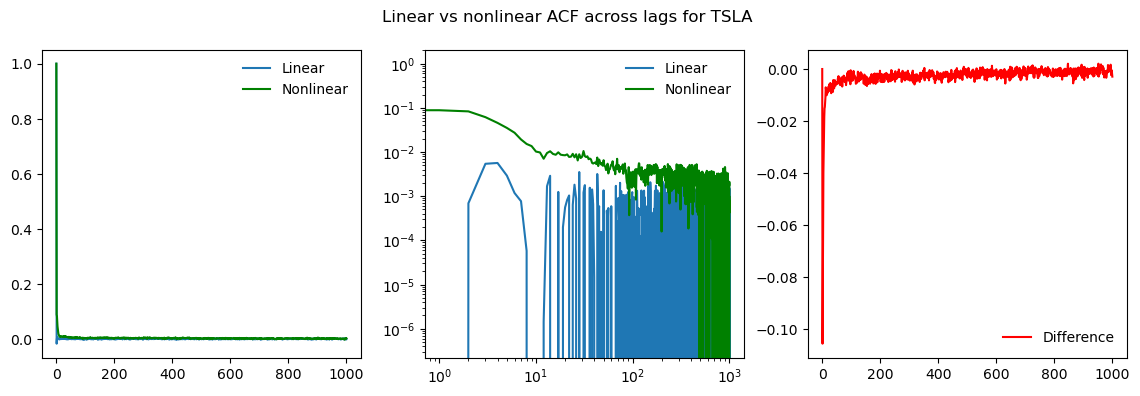

TSLA Max difference: 0.002055405057694492


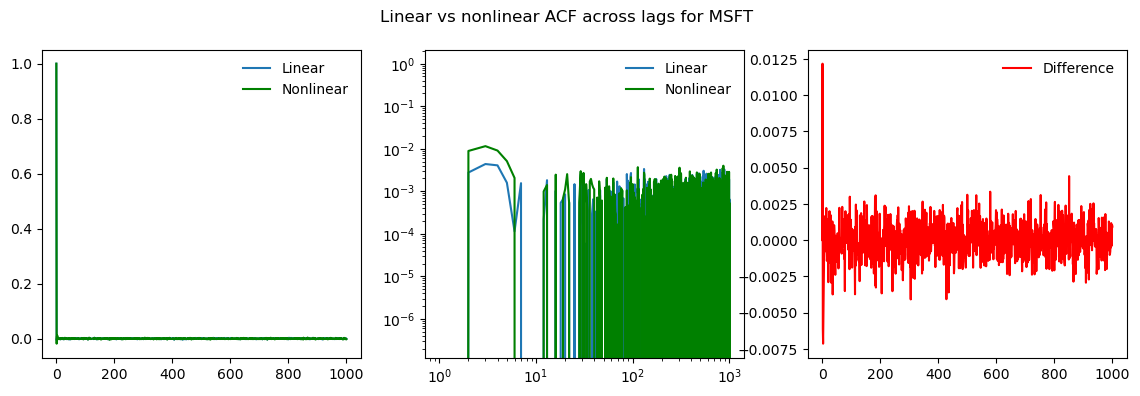

MSFT Max difference: 0.012157877947152874


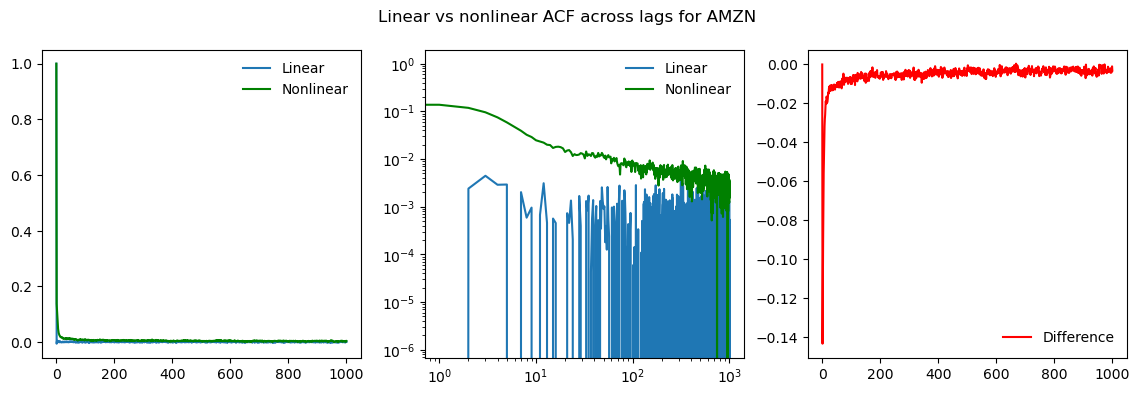

AMZN Max difference: 0.00040290614566501474


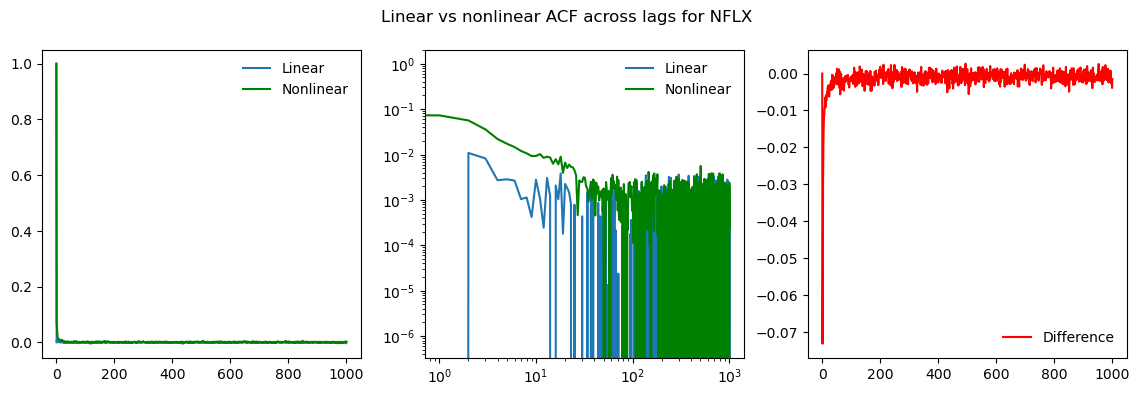

NFLX Max difference: 0.0026637602999851993


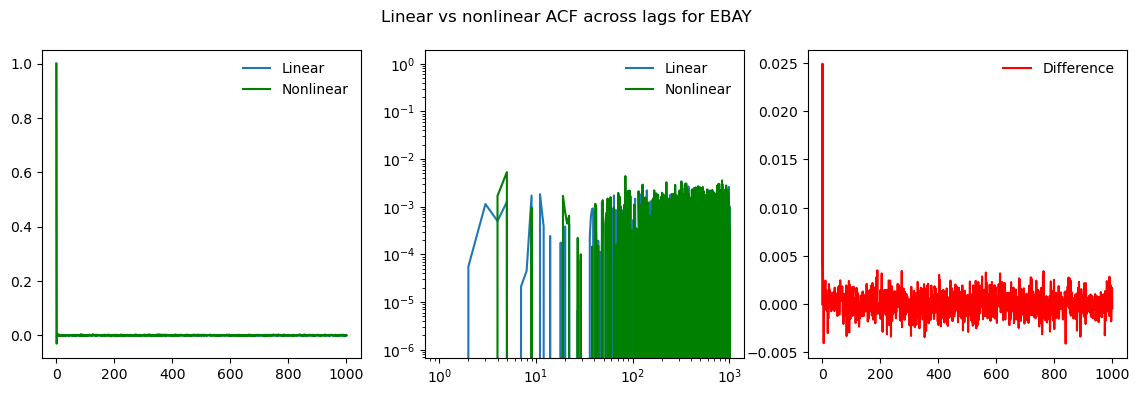

EBAY Max difference: 0.024929902866401628


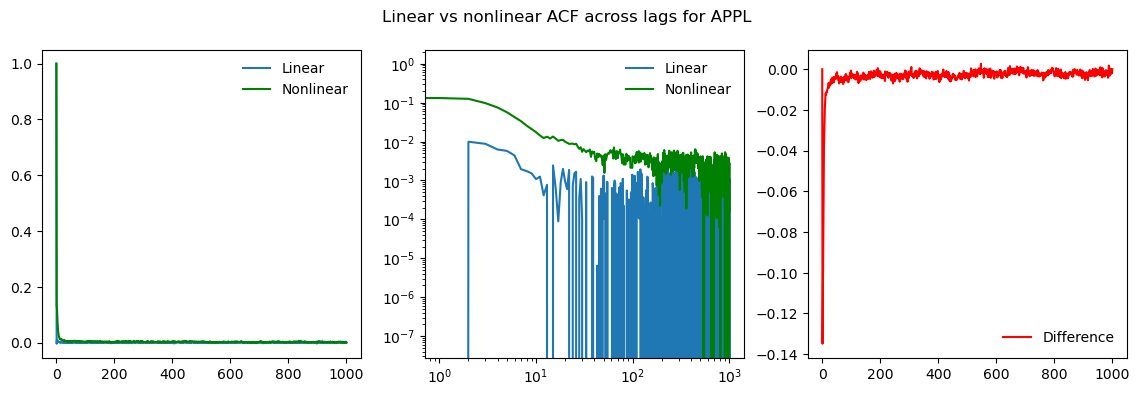

APPL Max difference: 0.002726712071826322


In [10]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

### 1.3. The Long Memory of Returns?

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

#### 1.3.1. Estimate ACF scaling parameter

In [11]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 5
xmin: 6.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.05291416464712349
alpha = -0.5462936920964292

Goodness of fit to data;
D = 0.2620481927710843
bic = -13192.405309495904
mape = 538.3108751100178
Adjusted R-squared = 0.680713365333538




#### 1.3.2. For all assets

In [12]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)

In [13]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0333803...",10,11.0,0.311806,-13423.961592,619.448284,0.596730,-0.457771,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0012664...",10,11.0,0.521695,-13269.969670,104.275545,-0.002640,-0.803632,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0613635...",10,11.0,0.177598,-13391.400465,31.296893,0.828965,-0.443880,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0284161...",10,11.0,0.311806,-13355.280560,448.811169,0.238140,-0.601297,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.014457...",10,11.0,0.466196,-13230.657873,118.125231,0.004892,-1.011037,EBAY


In [14]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [15]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: -0.622863942369833


In [16]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 1.4. Estimate Hurst Exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.

- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [17]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['returns'].cumsum()

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.08878075715410834
alpha = 0.508993923594669

Goodness of fit to data;
D = 0.019562715765247412
bic = -10551.07313765892
mape = 0.30398406286713664
Adjusted R-squared = 0.9998873360358317



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 28
xmin: 4.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.03435193222180402
alpha = 0.5866272248116898

Goodness of fit to data;
D = 0.010688836104513063
bic = -12636.526927697301
mape = 0.19143001871594847
Adjusted R-squared = 0.9999787658903939


Standard Hurst Exponent: 0.508993923594669 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5866272248116898 (Super-diffusive: series demonstrates persistent long-range dependence)


#### 1.4.1 For all assets

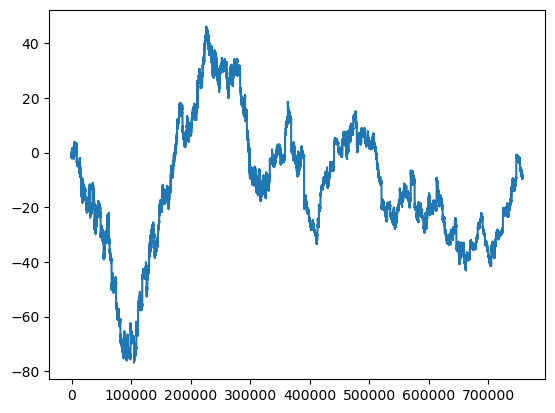

In [18]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['returns']
amzn_cum_returns = compute_returns(msft_raw_df)['returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['returns']
msft_cum_returns = compute_returns(nflx_raw_df)['returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['returns']
appl_cum_returns = compute_returns(appl_raw_df)['returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns.cumsum(),
  'MSFT': amzn_cum_returns.cumsum(),
  'AMZN': nflx_cum_returns.cumsum(),
  'NFLX': msft_cum_returns.cumsum(),
  'EBAY': ebay_cum_returns.cumsum(),
  'APPL': appl_cum_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
tsla_cumsum_returns = tsla_cum_returns = compute_returns(tsla_raw_df)['returns'].cumsum()
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [19]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0985433...",1,2.0,0.007082,-5066.924206,0.833948,0.998645,0.501762,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0106310...",1,2.0,0.016997,-8300.974446,0.845139,0.998605,0.491563,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2054964...",1,2.0,0.009915,-4027.177716,0.815208,0.998591,0.499329,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0358566...",1,2.0,0.019830,-6186.491176,1.085760,0.997821,0.499315,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0121828...",1,2.0,0.009915,-8383.933622,0.639360,0.999165,0.499587,EBAY,returns


In [20]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4989537748660573


In [21]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('APPL', 'standard', 'returns')])


In [22]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [23]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0325099...",1,2.0,0.005666,-7276.752553,0.682144,0.999902,0.614625,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0040208...",1,2.0,0.004249,-11641.481543,0.292923,0.999973,0.567671,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0562511...",1,2.0,0.005666,-6188.842616,0.825814,0.999850,0.616329,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0143676...",1,2.0,0.015581,-7990.941025,0.995172,0.999662,0.574255,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029515...",74,105.0,0.003160,-11060.947425,0.107604,0.999989,0.627037,EBAY,returns


In [24]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5676707068702513
Max Generalized Hurst: 0.6270371502447554
Average Generalized Hurst: 0.6010565793339879
Standard_dev Generalized Hurst: 0.024306646986086627


In [25]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('APPL', 'generalized', 'returns')])


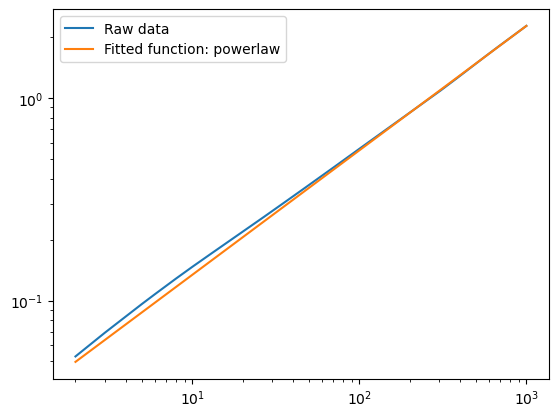

In [26]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 2. Percentage Returns

In [27]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### Stationarity Test

In [28]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.55
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.01
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.59
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.80
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 2.1. Percentage returns ACF

In [29]:
# Linear ACF
percentage_returns_linear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_linear_acfs.pkl"
percentage_returns_linear_acfs = compute_acfs(filename=percentage_returns_linear_acf_filename, data=percentage_returns, option='linear')
print(percentage_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [30]:
# Nonlinear ACF
percentage_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_nonlinear_acfs.pkl"
percentage_returns_nonlinear_acfs = compute_acfs(filename=percentage_returns_nonlinear_acf_filename, data=percentage_returns, option='nonlinear')
print(percentage_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


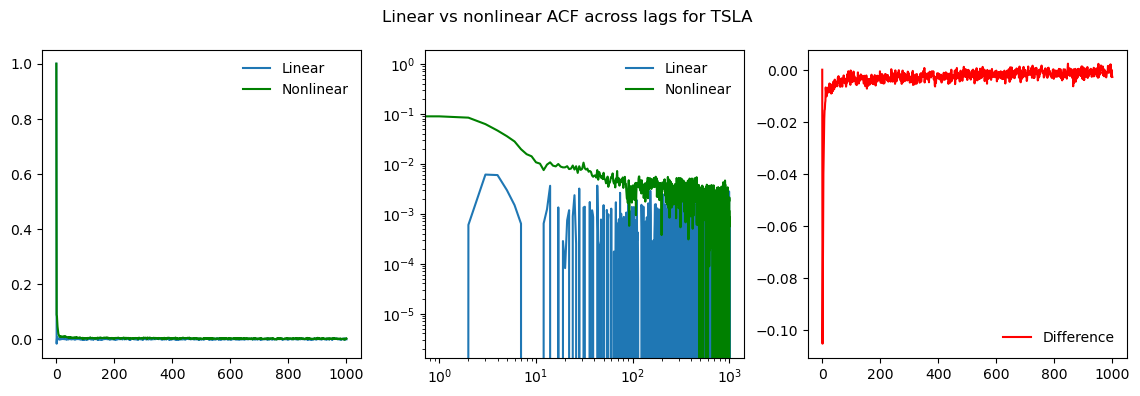

TSLA Max difference: 0.0023151439776839143


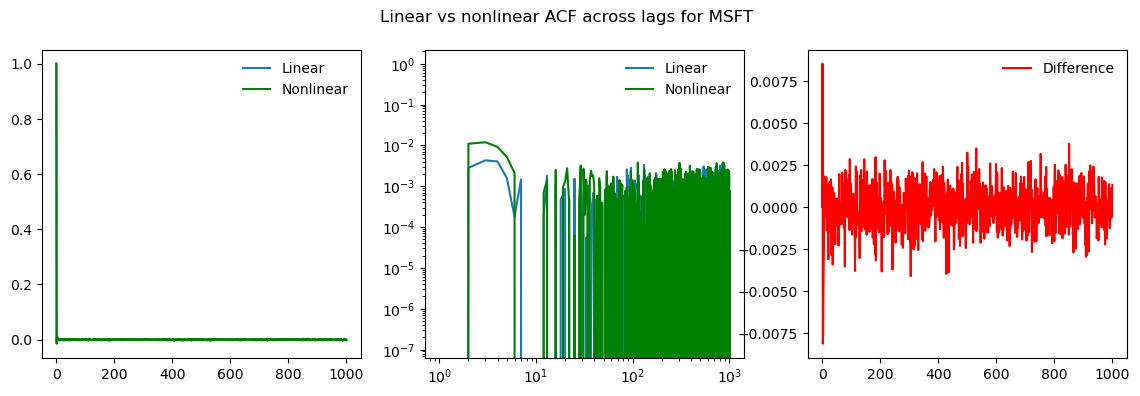

MSFT Max difference: 0.008514538356460268


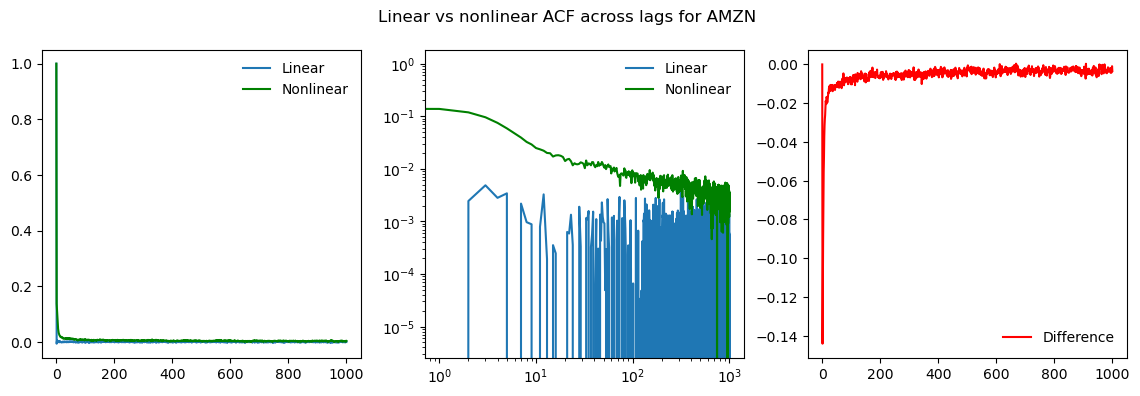

AMZN Max difference: 0.00037824016297907767


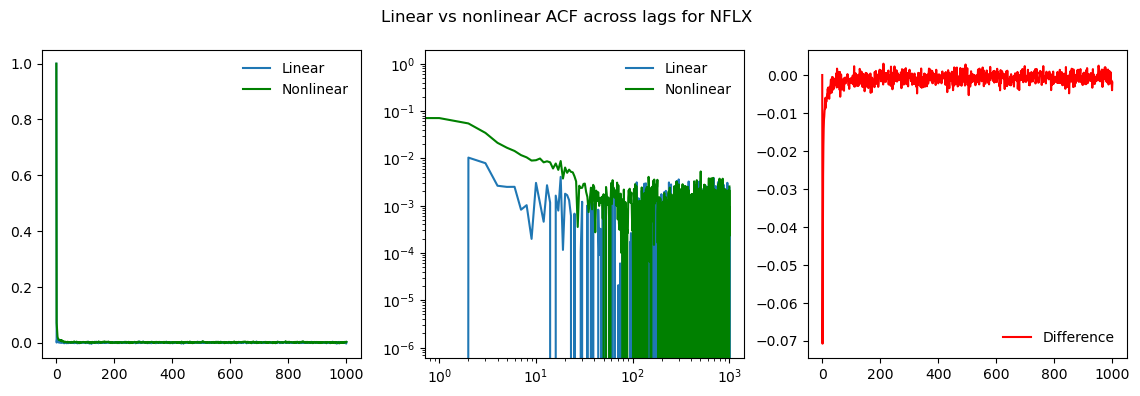

NFLX Max difference: 0.0029888530981321587


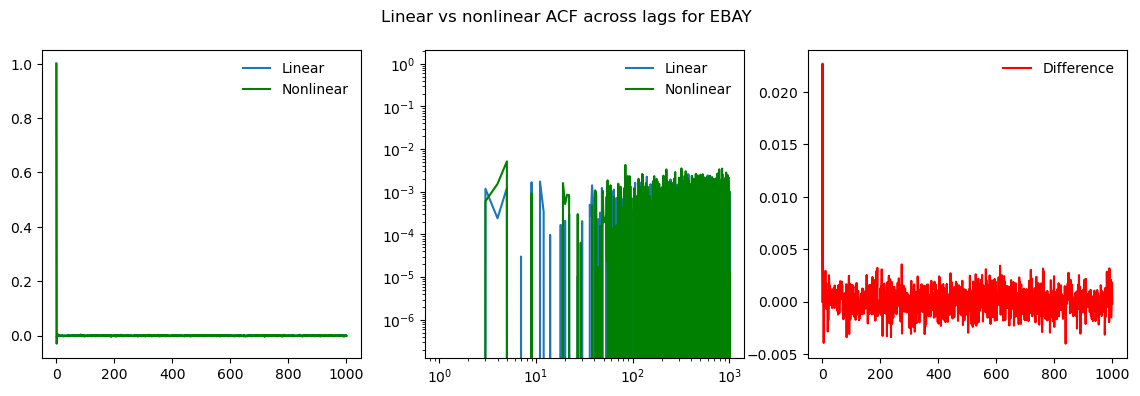

EBAY Max difference: 0.022672009173431134


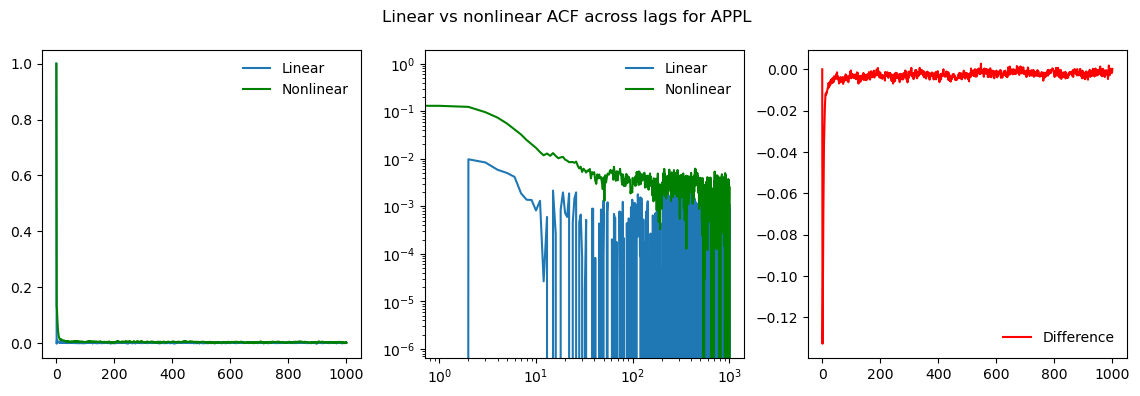

APPL Max difference: 0.0027181028695633666


In [31]:
for stock_name in percentage_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, percentage_returns_linear_acfs, percentage_returns_nonlinear_acfs)

### 2.2. Fit power law to percentage returns ACF

In [32]:
# Load the pre-computed ACFs
percentage_returns_acf_values = {}

for stock, data in percentage_returns_nonlinear_acfs.items():
    percentage_returns_acf_values[stock] = construct_xy(data, stock)

In [33]:
# Using percentage_return_acf_values
percentage_returns_fit_list = []
percentage_returns_fit_objects = {}

for stock, data in percentage_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        percentage_returns_fit_list.append(fit_dict)
        percentage_returns_fit_objects[stock] = fit_obj  # Store the fit object

percentage_returns_fit_results = pd.DataFrame(percentage_returns_fit_list)
display(percentage_returns_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0330879...",10,11.0,0.309788,-13443.029649,152.922796,0.604580,-0.451207,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0017633...",10,11.0,0.512614,-13258.513872,104.046030,-0.002242,-0.791188,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0616491...",10,11.0,0.189707,-13392.239101,32.004392,0.830983,-0.443765,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0286334...",10,11.0,0.317861,-13395.495175,307.394718,0.230997,-0.615568,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.018493...",10,11.0,0.482341,-13252.535264,129.693461,0.007289,-1.064512,EBAY


In [34]:
percentage_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [35]:
avg_alpha = percentage_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.6314267387507829


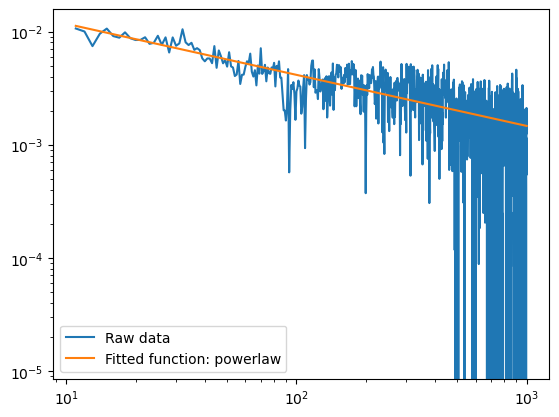

In [36]:
tsla_acf_fit = percentage_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3 Percentage returns Hurst Exponents

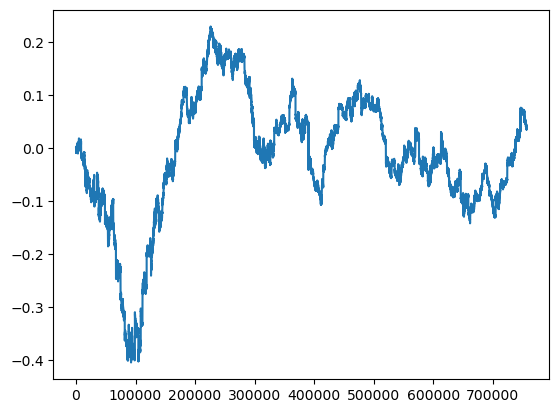

In [37]:
# Compute cumsum of percentage returns
cumsum_percentage_returns = {
  'TSLA': tsla_percentage_returns.cumsum(),
  'MSFT': msft_percentage_returns.cumsum(),
  'AMZN': amzn_percentage_returns.cumsum(),
  'NFLX': nflx_percentage_returns.cumsum(),
  'EBAY': ebay_percentage_returns.cumsum(),
  'APPL': appl_percentage_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_percentage_returns.items()}
tsla_cumsum_percentage_returns = tsla_percentage_returns.cumsum()
x = list(range(1, len(tsla_cumsum_percentage_returns)+1))
plt.plot(x, tsla_cumsum_percentage_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [38]:
# Standard Hurst
method = 'standard'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_std_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0005209...",1,2.0,0.009915,-12326.050127,1.053578,0.998072,0.491906,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002061...",1,2.0,0.015581,-13872.346406,0.852027,0.998607,0.491290,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003478...",1,2.0,0.009915,-13002.405226,0.819751,0.998531,0.499902,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003696...",1,2.0,0.016997,-12686.748560,1.069538,0.997886,0.497563,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004539...",1,2.0,0.012748,-12946.461183,0.676922,0.999067,0.500022,EBAY,percentage_returns


In [39]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = percentage_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.49666634838019386


In [40]:
display(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'percentage_returns'), ('MSFT', 'standard', 'percentage_returns'), ('AMZN', 'standard', 'percentage_returns'), ('NFLX', 'standard', 'percentage_returns'), ('EBAY', 'standard', 'percentage_returns'), ('APPL', 'standard', 'percentage_returns')])

#### Generalized Hurst

In [41]:
# Generalized Hurst
method = 'generalized'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_gen_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001579...",1,2.0,0.005666,-14911.181184,0.626574,0.999915,0.613473,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 7.7933112...",1,2.0,0.004249,-17231.309528,0.289973,0.999974,0.567509,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 9.4191115...",1,2.0,0.005666,-15171.556079,0.851639,0.999843,0.617383,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001460...",1,2.0,0.015581,-14399.947352,1.037546,0.999629,0.574654,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001128...",1,2.0,0.004249,-15446.591159,0.630299,0.999935,0.626044,EBAY,percentage_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.8244437...",1,2.0,0.011331,-15139.316820,0.893026,0.999783,0.607671,APPL,percentage_returns


In [42]:
# Generalized Hurst statistic across stocks
min_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = percentage_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5675090520541008
Max Generalized Hurst: 0.6260441570353359
Average Generalized Hurst: 0.6011222825297353
Standard_dev Generalized Hurst: 0.024130198198340544


In [43]:
print(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'percentage_returns'), ('MSFT', 'generalized', 'percentage_returns'), ('AMZN', 'generalized', 'percentage_returns'), ('NFLX', 'generalized', 'percentage_returns'), ('EBAY', 'generalized', 'percentage_returns'), ('APPL', 'generalized', 'percentage_returns')])


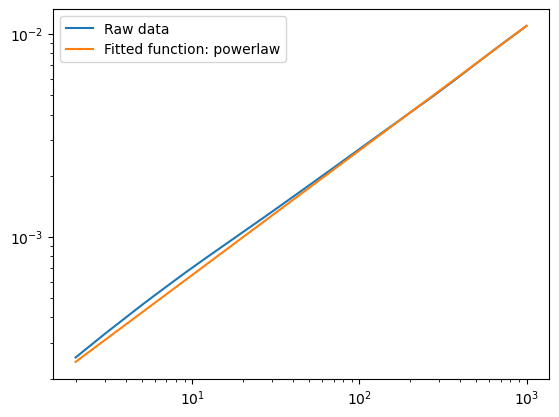

In [44]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = percentage_returns_fit_objects[('TSLA', 'generalized', 'percentage_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Log Returns

In [45]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df)['log_returns']
msft_log_returns = compute_returns(msft_raw_df)['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df)['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df)['log_returns']
appl_log_returns = compute_returns(appl_raw_df)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### Stationarity Test

In [46]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -350.98
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.60
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.79
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.1. Log returns ACF

In [47]:
# Linear ACF
log_returns_linear_acf_filename = f"{acf_data_dir}/mo_log_returns_linear_acfs.pkl"
log_returns_linear_acfs = compute_acfs(filename=log_returns_linear_acf_filename, data=log_returns, option='linear')
print(log_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [48]:
# Nonlinear ACF
log_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_log_returns_nonlinear_acfs.pkl"
log_returns_nonlinear_acfs = compute_acfs(filename=log_returns_nonlinear_acf_filename, data=log_returns, option='nonlinear')
print(log_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


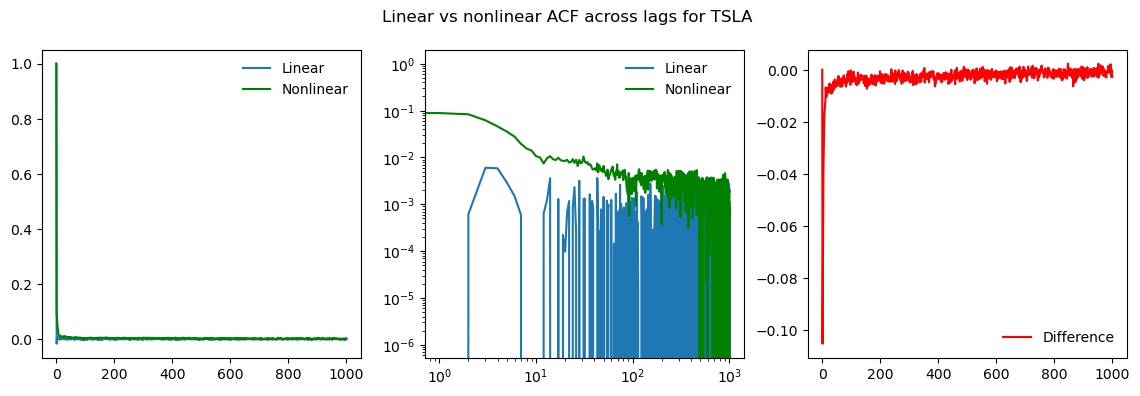

TSLA Max difference: 0.00230827664713109


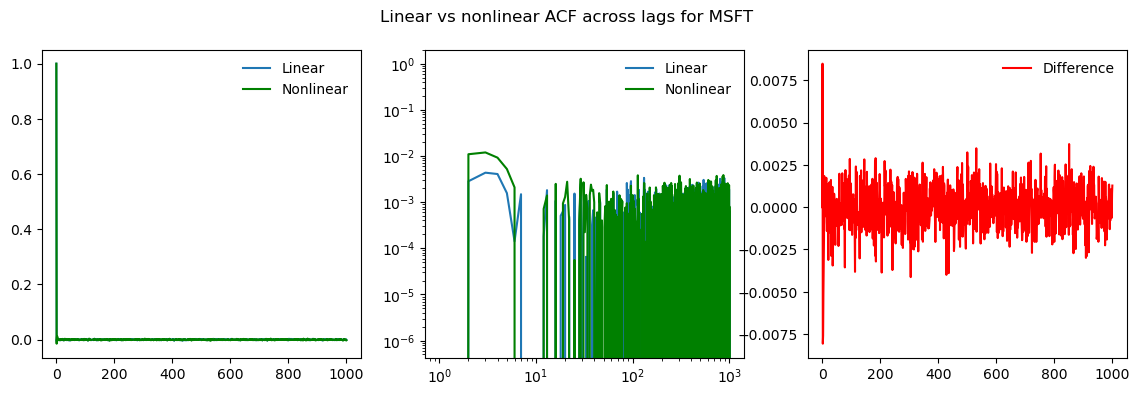

MSFT Max difference: 0.008487658917489461


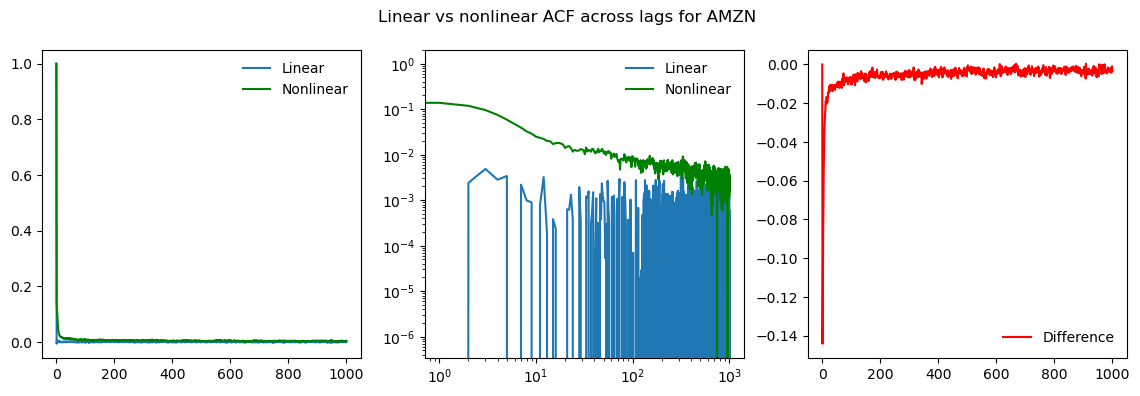

AMZN Max difference: 0.0003795790168207181


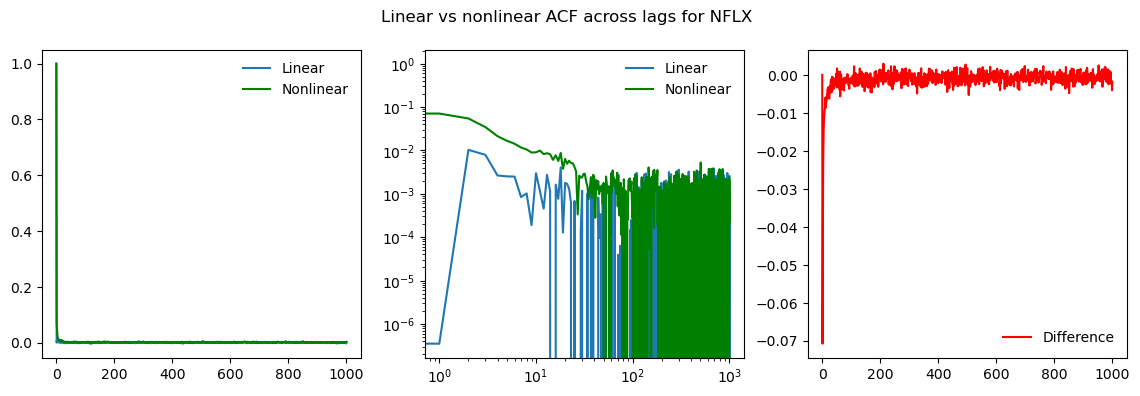

NFLX Max difference: 0.00294599452173891


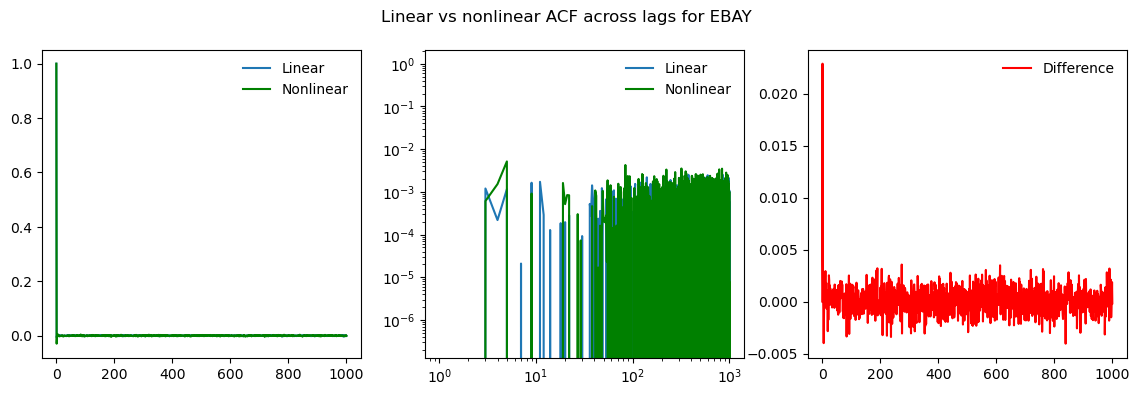

EBAY Max difference: 0.022871123630972767


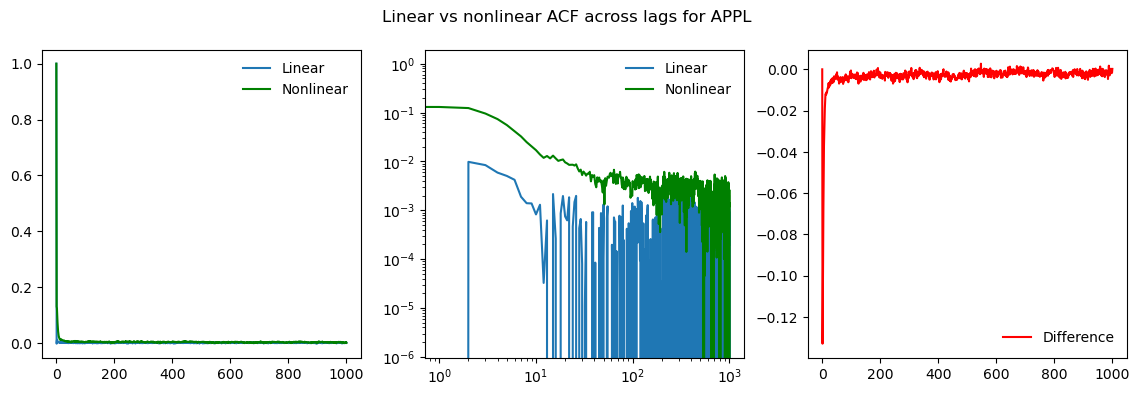

APPL Max difference: 0.0027326150422147446


In [49]:
for stock_name in log_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, log_returns_linear_acfs, log_returns_nonlinear_acfs)

### 3.2. Fit power law to log retrurns ACF

In [50]:
# Load the pre-computed ACFs
log_returns_acf_values = {}

for stock, data in log_returns_nonlinear_acfs.items():
    log_returns_acf_values[stock] = construct_xy(data, stock)

In [51]:
# Using log_returns_nonlinear_acfs
log_returns_fit_results_list = []
log_returns_fit_objects = {}  # Dictionary to store fit objects

for stock, data in log_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[stock] = fit_obj  # Store the fit object

log_returns_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0330545...",10,11.0,0.308779,-13442.402632,132.954103,0.604292,-0.450867,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0018777...",10,11.0,0.514632,-13259.210236,112.112752,-0.002208,-0.803658,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0616861...",10,11.0,0.188698,-13392.146895,31.653342,0.831006,-0.444009,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0284719...",10,11.0,0.321897,-13396.052812,1826.812320,0.230844,-0.614160,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.018668...",10,11.0,0.483350,-13252.702428,130.595603,0.007319,-1.067249,EBAY
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0300836...",10,11.0,0.269425,-13267.819891,936.238965,0.513934,-0.421865,APPL


In [52]:
log_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [53]:
avg_alpha = log_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.6336346279969368


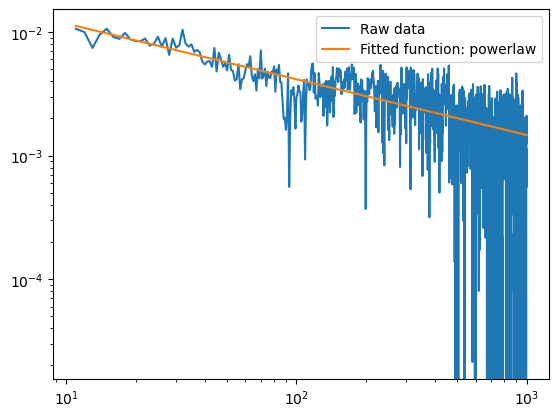

In [54]:
tsla_acf_fit = log_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Log returns Hurst Exponents

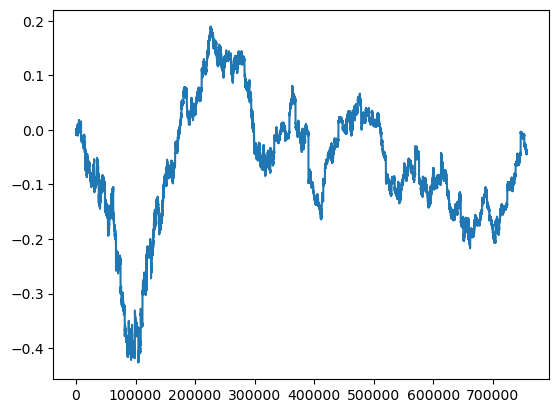

In [55]:
cumsum_log_returns = {
  'TSLA': tsla_log_returns.cumsum(),
  'MSFT': msft_log_returns.cumsum(),
  'AMZN': amzn_log_returns.cumsum(),
  'NFLX': nflx_log_returns.cumsum(),
  'EBAY': ebay_log_returns.cumsum(),
  'APPL': appl_log_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_log_returns.items()}
tsla_cumsum_log_returns = compute_returns(tsla_raw_df)['log_returns'].cumsum()
x = list(range(1, len(tsla_cumsum_log_returns)+1))
plt.plot(x, tsla_cumsum_log_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [56]:
# Standard Hurst
method = 'standard'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_std_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_std_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0005212...",1,2.0,0.009915,-12333.801542,1.040467,0.998099,0.492074,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002055...",1,2.0,0.015581,-13858.304144,0.864185,0.998566,0.491058,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003476...",1,2.0,0.011331,-13017.009773,0.817490,0.998561,0.499960,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003697...",1,2.0,0.016997,-12694.804484,1.061241,0.997914,0.497640,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004607...",1,2.0,0.011331,-12938.898882,0.672944,0.999085,0.500056,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002866...",1,2.0,0.021246,-13418.237006,0.793488,0.998790,0.499529,APPL,log_returns


In [57]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = log_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4967194482815789


In [58]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'log_returns'), ('MSFT', 'standard', 'log_returns'), ('AMZN', 'standard', 'log_returns'), ('NFLX', 'standard', 'log_returns'), ('EBAY', 'standard', 'log_returns'), ('APPL', 'standard', 'log_returns')])

#### Generalized Hurst

In [59]:
# Generalized Hurst
method = 'generalized'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_gen_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugae

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001577...",1,2.0,0.005666,-14901.501798,0.631020,0.999914,0.613699,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 7.7984663...",1,2.0,0.004249,-17234.182877,0.288852,0.999974,0.567298,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 9.4210288...",1,2.0,0.005666,-15174.686742,0.849947,0.999844,0.617349,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001459...",1,2.0,0.015581,-14395.813077,1.040873,0.999628,0.574857,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001125...",1,2.0,0.005666,-15434.509175,0.635530,0.999934,0.626641,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.8385309...",1,2.0,0.011331,-15147.651928,0.887736,0.999785,0.607238,APPL,log_returns


In [60]:
# Generalized Hurst statistic across stocks
min_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = log_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5672983266898777
Max Generalized Hurst: 0.6266413633920451
Average Generalized Hurst: 0.6011804422596915
Standard_dev Generalized Hurst: 0.024265278501834863


In [61]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'log_returns'), ('MSFT', 'generalized', 'log_returns'), ('AMZN', 'generalized', 'log_returns'), ('NFLX', 'generalized', 'log_returns'), ('EBAY', 'generalized', 'log_returns'), ('APPL', 'generalized', 'log_returns')])

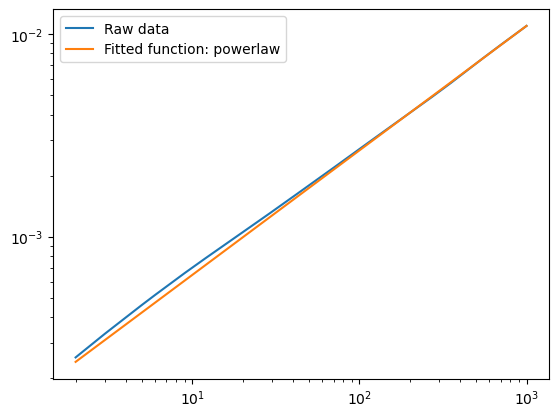

In [62]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = log_returns_fit_objects[('TSLA', 'generalized', 'log_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Return magnitudes

In [63]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

### Stationarity Test

In [64]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -49.89
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -52.60
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.20
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.1. Return magnitude ACF

In [65]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/mo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
display(volatility_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [66]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/mo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
display(volatility_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

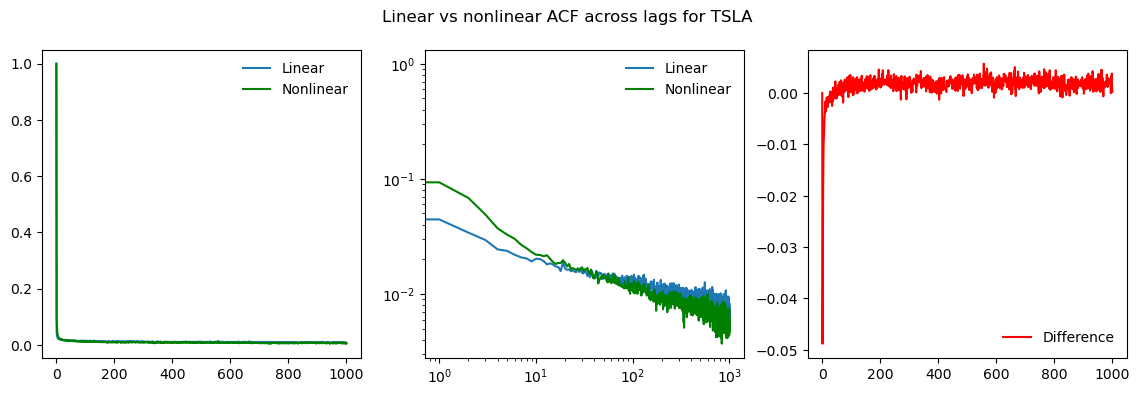

TSLA Max difference: 0.005707488396366474


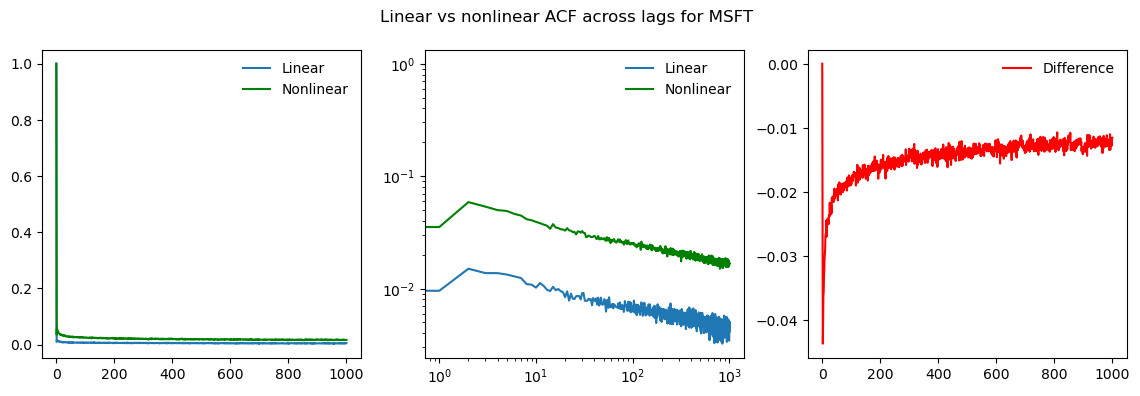

MSFT Max difference: 0.0


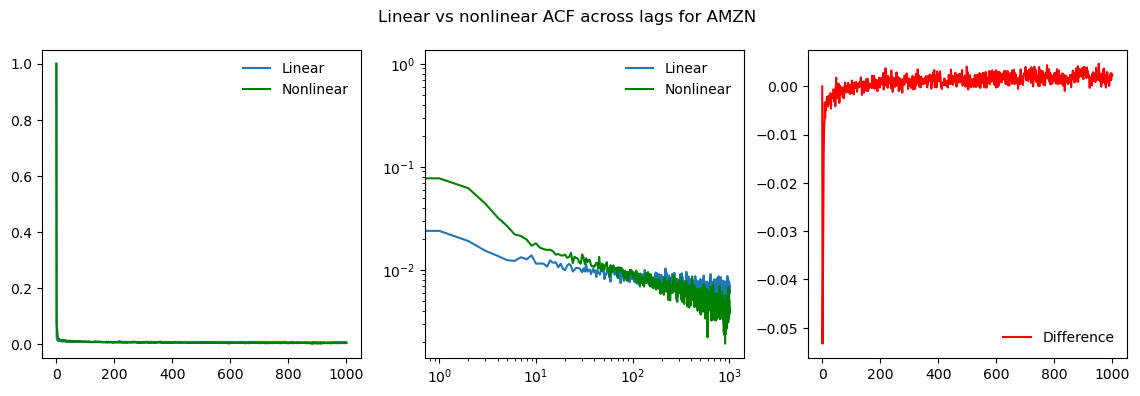

AMZN Max difference: 0.004692378619647593


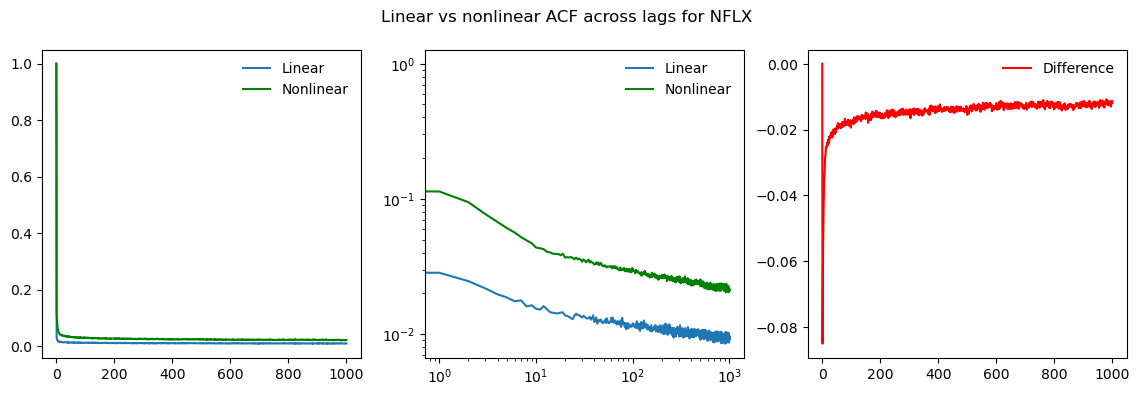

NFLX Max difference: 0.0


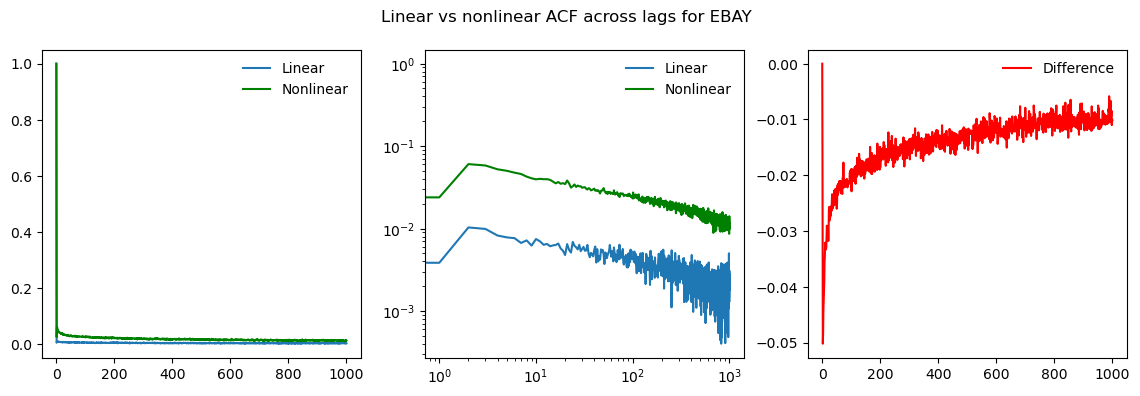

EBAY Max difference: 0.0


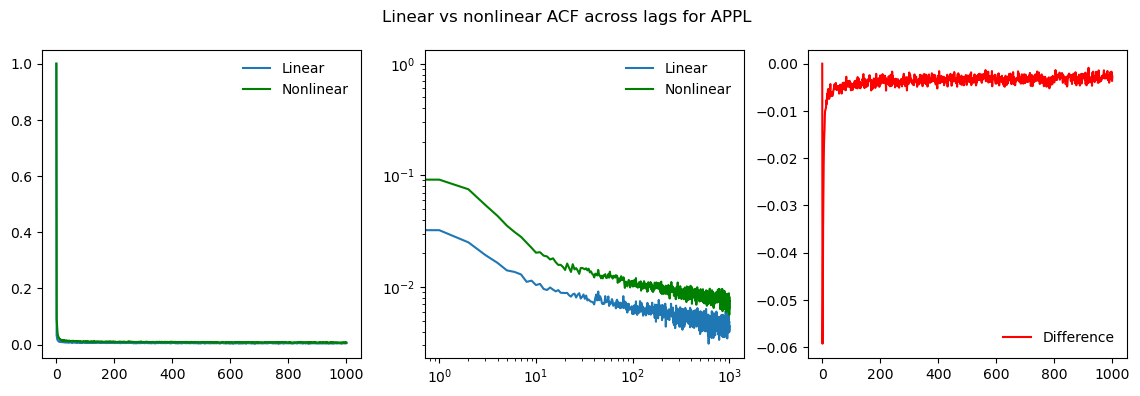

APPL Max difference: -2.220446049250313e-16


In [67]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 4.2. Fit power law to ACF

In [68]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [69]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0468630...",4,5.0,0.122367,-13818.246692,9.821043,0.901451,-0.299782,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0604368...",3,4.0,0.054108,-14078.359270,3.131537,0.958967,-0.188838,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0441015...",3,4.0,0.128257,-13746.901322,11.865147,0.872388,-0.344423,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0574695...",9,10.0,0.044355,-14430.813882,2.152771,0.961681,-0.144089,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1481262...",235,236.0,0.112272,-10222.942148,7.194117,0.753925,-0.368430,EBAY


In [70]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.25647861456768223


In [71]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

### 4.3.Volatility Hurst Exponents

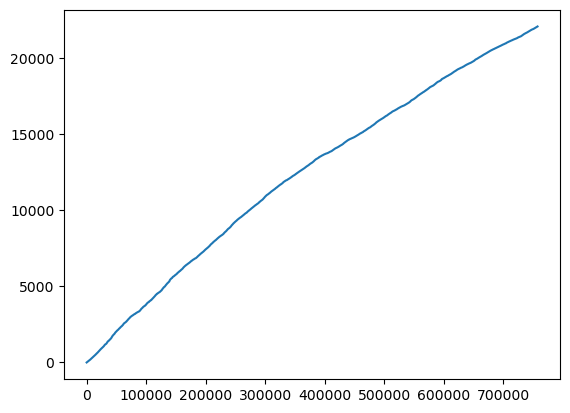

In [72]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

cumsum_return_magnitudes = {
  'TSLA': tsla_volatility.cumsum(),
  'MSFT': msft_volatility.cumsum(),
  'AMZN': amzn_volatility.cumsum(),
  'NFLX': nflx_volatility.cumsum(),
  'EBAY': ebay_volatility.cumsum(),
  'APPL': appl_volatility.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = tsla_volatility.cumsum()
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [73]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0328730...",1,2.0,0.009915,-4108.888122,2.177744,0.999588,0.822186,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029916...",1,2.0,0.014164,-7326.785134,2.728687,0.999347,0.806963,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0536906...",63,90.0,0.013975,-2940.726817,1.138371,0.999453,0.837527,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0100428...",1,2.0,0.011331,-5346.063809,2.672239,0.999453,0.845831,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0048788...",1,2.0,0.011331,-7318.545834,2.211088,0.999249,0.730518,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0376677...",1,2.0,0.015581,-4563.092515,2.268752,0.998729,0.682113,APPL,volatility


In [74]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7875230677869006


#### Generalized Hurst

In [75]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0322025...",1,2.0,0.001416,-13568.168427,0.000913,1.0,1.000067,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0036106...",1,2.0,0.001416,-13863.422664,0.007161,1.0,0.999844,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0512953...",1,2.0,0.001416,-11443.021628,0.002935,1.0,1.000069,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0138521...",1,2.0,0.001416,-12574.752075,0.005988,1.0,0.999779,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0031951...",1,2.0,0.001416,-16450.835160,0.000844,1.0,0.999945,EBAY,volatility


In [76]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9996128564460067
Max Generalized Hurst: 1.0000687142348954
Average Generalized Hurst: 0.9998861593963344
Standard_dev Generalized Hurst: 0.00017748434899418985


In [77]:
print(volatility_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volatility'), ('MSFT', 'generalized', 'volatility'), ('AMZN', 'generalized', 'volatility'), ('NFLX', 'generalized', 'volatility'), ('EBAY', 'generalized', 'volatility'), ('APPL', 'generalized', 'volatility')])


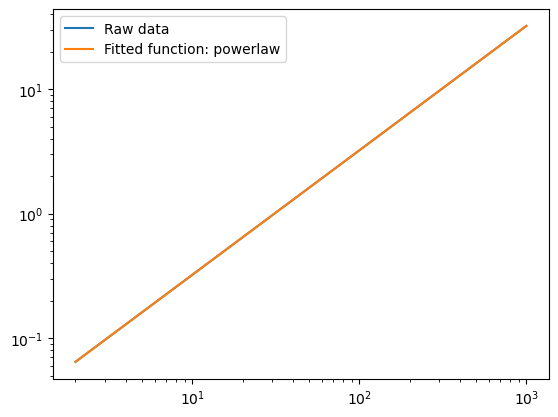

In [78]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volatility_fit_objects[('TSLA', 'generalized', 'volatility')]
tsla_generalized_fit.powerlaw.plot_fit()